In [1]:
import torch
import functools
import numpy  as np
from IPython.core.debugger import set_trace
import torchvision
from tqdm import trange

%pylab inline

Populating the interactive namespace from numpy and matplotlib


https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

Функция регистр добавляет в класс тензор метод mul, т.к.
мул наследуется от класса Function то он имеет метод apply
именно туда мы и перейдем

        - setattr(Tensor, name, functools.partialmethod(fn.apply, fn))
        - fn это мул <class '__main__.Mul'>
        - name = 'mul'
        - затем попав в метод apply (fn.apply)
            - arg(fn) это аргумент который мы передали в apply

и получается что  ctx это класс MUl, вызывает класс Tensor и передаем в него 
        
        - Tensor(arg.forward(ctx, self.data, *[t.data for t in x]))
        - self this a = 1
        - arg <class '__main__.Mul'>
        - x = 3 or b
        - self.data => 1.data=> self this tensor after .data get array [1]
        - 'подставим'
        - Mul.forward (x= ( self.data, y = *[t.data for t in x]))
            - save x, y
            - mul x * y 
- ctx это класс мул он передается для сохранения значений x, y
(method save tensor)
- затем мы сохраняем ctx  в переменную _ctx  класса тензор
- затем если мы выполним метод backward in class Tensor
произойдет следующие

        - пока не вызвали(backward) в классе Tensor есть
        только результат мул и сохраненный класс мул
        - и так вызываем

        if self._ctx is None:
            return
            проходим тк не нон
        if self.grad is None and fill:
            # iniy first grad ones
            assert self.data.size == 1
            self.grad = np.ones_like(self.data)      
        assert(self.grad is not None) 
        
        инициализируем градиент единицами, self.grad = [1]

        grads = self._ctx.backward(self._ctx, self.grad)
        
        grads = (array([3]), array([1]))
        - Mul.backward
        
            def backward(ctx, grad_out):      
                x, y = ctx.saved_tensors =>  [array([1]), array([3])] 
                return y * grad_out, x * grad_out

        получаем сохраненные значения изначальные
        затем умножаем на градиент он равен 1 пока что
        и возвращаем полученные значения
        ctx.parents  это тензоры а и б
            
            if len(self._ctx.parents) == 1:
                grads = [grads]

        это сделано чтоб использовать зип
            
            - self._ctx.parents (tensor([1]), tensor([3])),
            - grads = (array([3]), array([1]))

            for t, g in zip(self._ctx.parents, grads):
                # t  Tensor
                if g.shape != t.data.shape:
                    print('grad shape must match tensor shape')
                    assert(False)           
                t.grad = g

In [46]:
# make base class
class Tensor:
    def __init__(self, data):

        if type(data) != np.ndarray:
            set_trace()
            print('error type data %r' % data)
            assert(False)
        self.data = data        
        self.grad = None
        self._ctx = None
    
    def __repr__(self):
        # tensor([1.]))
        return f'tensor({self.data})'

    def backward(self, fill = True):
        
        # print("running backward on", self)

        if self._ctx is None:
            return

        if self.grad is None and fill:
            # iniy first grad ones
            assert self.data.size == 1
            self.grad = np.ones_like(self.data)
        
        assert(self.grad is not None)  

        """
        _ctx.backward return from <class '__main__.Mul'> 
        and method Mul.backward return y * grad_out, x * grad_out
        
        """      
        grads = self._ctx.backward(self._ctx, self.grad)
        # print('Func name: ',type(self._ctx))
        # print('Grad: ', self.grad.shape)
        # print('Self: ', self.data.shape)
        # set_trace()
        if len(self._ctx.parents) == 1:
            grads = [grads]

        # print(self._ctx.parents, grads)

        for t, g in zip(self._ctx.parents, grads):
            # t  Tensor
            """
            print(g.shape,t.data.shape)

                    (1,) (1,)
                    (30, 10) (30, 10)
                    (30, 10) (30, 10)
                    (1, 30, 10) (30, 10)
                    (30, 128) (30, 128)
                    (30, 128) (30, 128)
                    (30, 784) (30, 784)
                    (784, 128) (784, 128)
                    (128, 10) (128, 10)
                    (30, 10) (30, 10)
                    (1,) (1,)             
            """     
            # print(g.shape, t.data.shape)
            if g.shape != t.data.shape :
                g = np.squeeze(g)
              
            
            if g.shape != t.data.shape:
                print('grad shape must match tensor shape')                
                assert(False)
            t.grad = g           
            t.backward(False)          
      
         

"""
https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html#:~:text=beginner%2Fexamples_autograd%2Ftwo_layer_net_custom_function-,PyTorch%3A%20Defining%20New%20autograd%20Functions,PyTorch%20autograd%20to%20compute%20gradients.
В прямом проходе мы получаем тензор, содержащий ввод и возврат
Тензор, содержащий вывод. 

ctx - это объект контекста, который можно использовать
хранить информацию для обратных вычислений. Вы можете кешировать произвольные
объекты для использования в обратном проходе с помощью метода ctx.save_for_backward.


При обратном проходе мы получаем тензор, содержащий градиент потери
относительно выхода, и нам нужно вычислить градиент потерь относительно входа.

"""

class Function:

    def __init__(self, *tensor):
        self.parents = tensor  
        self.saved_tensors = []
    
    def save_for_backward(self, *x):
        self.saved_tensors.extend(x)    

    def apply(self, arg, *x):
        """
        почему мы здесь а потому что fn.apply и передаем аргумент fn
        a = Tensor(np.array([1]))
        b = Tensor(np.array([3]))
        
        a.mul(b)
        
        arg: <class '__main__.Mul'> , fn
        self.data -> Tensor.data->[1] a
        [3] = b        
        
        """        
        ctx = arg(self, *x)         
        ret = Tensor(arg.forward(ctx, self.data, *[t.data for t in x]))
        ret._ctx = ctx
        return ret


def register(name, fn):
    """
    class A:
        print('hell')
    a = A()
    setattr(a, 'oo', lambda x: x *2)
    a.oo(2)
    >4

    we add mul to class Tensor    

    partialmethod(fumc, arg)
    """    
    # set_trace()
    setattr(Tensor, name, functools.partialmethod(fn.apply, fn))


class Mul(Function):
    """
    out = x.mul.y
    back
    out/dx, out/dy
    
    """

    @staticmethod
    def forward(ctx, x, y):
        ctx.save_for_backward(x, y)
        return x * y

    @staticmethod
    def backward(ctx, grad_out):       
        # set_trace()
        x, y = ctx.saved_tensors       
        return y * grad_out, x * grad_out

register('mul', Mul)

class Add(Function):
    """sum"""
    @staticmethod
    def forward(ctx, x, y):
        ctx.save_for_backward(x, y)
        return x + y

    @staticmethod
    def backward(ctx, grad_out):     
        x, y = ctx.saved_tensors       
        return grad_out, grad_out


class ReLU(Function):
    """relu"""
    @staticmethod
    def forward(ctx, in_val):
        ctx.save_for_backward(in_val)
        return np.maximum(in_val, 0)

    @staticmethod
    def backward(ctx, grad_out):     
        in_val = ctx.saved_tensors         
        grad_out[in_val[0] < 0] = 0   
        return grad_out

register('relu', ReLU)        

class Sum(Function):
    """sum array each dx is 1"""
    @staticmethod
    def forward(ctx, in_val):
       
        ctx.save_for_backward(in_val)
        return np.array([in_val.sum()])

    @staticmethod
    def backward(ctx, grad_out):
        # set_trace()     
        in_val = ctx.saved_tensors #!!!!!!!!!!!!!!!!!!!!!!!!!!            
        return grad_out * np.ones_like(in_val[0])


register('sum', Sum)

class Dot(Function):
    """
    a = [[1, 0], [0, 1]]
    b = [[4, 1], [2, 2]]
    np.dot(a, b)
    >> array([[4, 1],
             [2, 2]])  
    
    """
    @staticmethod
    def forward(ctx, in_val, w):
        ctx.save_for_backward(in_val, w)
        return in_val.dot(w)

    @staticmethod
    def backward(ctx, grad_out):     
        in_val, w = ctx.saved_tensors
        # set_trace()
        # grad_out = np.squeeze(grad_out)
        g_grad = grad_out.dot(w.T) # (10,10,1) and (128,10)  after 10, 128
        w_grad = grad_out.T.dot(in_val).T
        return g_grad, w_grad

register('dot', Dot)


class Log_softmax(Function):

    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        mx = x.max(axis=1)
        stbl = mx + np.log(np.exp(x- mx.reshape((-1, 1))).sum(axis=1))        
        return x - stbl.reshape(-1,1)        

    @staticmethod
    def backward(ctx, grad_out):     
        x = ctx.saved_tensors
        # set_trace() 
        return  grad_out - np.exp(x)*grad_out.sum(axis=1).reshape((-1, 1))      
 
register('log_softmax', Log_softmax)

In [3]:
a = Tensor(np.array([1]))
b = Tensor(np.array([3]))
c = a.mul(b)
# check how works
print('No grad: ', a.grad, b.grad)
c.backward()
print('Numpy grad: ', c)
print('Numpy Grad: ', a.grad, b.grad)
print('-----------------')
print('Time to torch')
a  = torch.tensor([1.], requires_grad=True)
b  = torch.tensor([3.], requires_grad=True)
c = a.matmul(b)
c.backward()
print('Torch grad: ', c)
print('Torch Grad: ', a.grad, b.grad)

No grad:  None None
Numpy grad:  tensor([3])
Numpy Grad:  [3] [1]
-----------------
Time to torch
Torch grad:  tensor(3., grad_fn=<DotBackward>)
Torch Grad:  tensor([3.]) tensor([1.])


## Test NN

In [4]:
import requests, gzip, os, hashlib

In [40]:
"""
why, because torchvision.datasets.MNIST(root= './', download=True) not work
HTTPError: HTTP Error 403: Forbidden
"""
def load_data(url : str) -> np.array:
    """
    https://www.geeksforgeeks.org/md5-hash-python/
    https://pytorch.org/tutorials/beginner/nn_tutorial.html
    idea not use name, hash?    
    
    """    
    tmp = os.path.join('/content/', hashlib.md5(url.encode('utf-8')).hexdigest())    
    if os.path.isfile(tmp):
        with open(tmp, 'rb') as f:
            d = f.read()
    else:
        with open(tmp, 'wb') as f:
            d = requests.get(url).content
            f.write(d)
    return np.frombuffer(gzip.decompress(d), dtype = np.uint8)

x = load_data("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28))
y = load_data("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]

x_test = load_data("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28))
y_test = load_data("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

x.shape, y.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

















  0%|          | 0/500 [00:00<?, ?it/s]















Loss:  0.241, Accuracy: 0.033:   0%|          | 0/500 [00:00<?, ?it/s]















Loss:  0.294, Accuracy: 0.133:   0%|          | 0/500 [00:00<?, ?it/s]















Loss:  0.226, Accuracy: 0.200:   0%|          | 0/500 [00:00<?, ?it/s]















Loss:  0.205, Accuracy: 0.400:   0%|          | 0/500 [00:00<?, ?it/s]















Loss:  0.194, Accuracy: 0.433:   0%|          | 0/500 [00:00<?, ?it/s]















Loss:  0.189, Accuracy: 0.300:   0%|          | 0/500 [00:00<?, ?it/s]















Loss:  0.206, Accuracy: 0.267:   0%|          | 0/500 [00:00<?, ?it/s]















Loss:  0.180, Accuracy: 0.433:   0%|          | 0/500 [00:00<?, ?it/s]















Loss:  0.195, Accuracy: 0.333:   0%|          | 0/500 [00:00<?, ?it/s]















Loss:  0.195, Accuracy: 0.333:   2%|▏         | 9/500 [00:00<00:05, 83.49it/s]















Loss:  0.187, Accuracy: 0.467:   2%|▏         | 9/500 [00:00<

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.157, Accuracy: 0.600:   2%|▏         | 9/500 [00:00<00:05, 83.49it/s]















Loss:  0.157, Accuracy: 0.600:   4%|▎         | 18/500 [00:00<00:05, 82.63it/s]















Loss:  0.149, Accuracy: 0.567:   4%|▎         | 18/500 [00:00<00:05, 82.63it/s]















Loss:  0.137, Accuracy: 0.633:   4%|▎         | 18/500 [00:00<00:05, 82.63it/s]















Loss:  0.160, Accuracy: 0.567:   4%|▎         | 18/500 [00:00<00:05, 82.63it/s]















Loss:  0.133, Accuracy: 0.667:   4%|▎         | 18/500 [00:00<00:05, 82.63it/s]















Loss:  0.141, Accuracy: 0.533:   4%|▎         | 18/500 [00:00<00:05, 82.63it/s]















Loss:  0.121, Accuracy: 0.767:   4%|▎         | 18/500 [00:00<00:05, 82.63it/s]















Loss:  0.132, Accuracy: 0.633:   4%|▎         | 18/500 [00:00<00:05, 82.63it/s]















Loss:  0.122, Accuracy: 0.733:   4%|▎         | 18/500 [00:00<00:05, 82.63it/s]















Loss:  0.133, Accuracy: 0.700:   4%

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.108, Accuracy: 0.767:   5%|▌         | 27/500 [00:00<00:05, 84.11it/s]















Loss:  0.108, Accuracy: 0.767:   7%|▋         | 34/500 [00:00<00:06, 75.60it/s]















Loss:  0.109, Accuracy: 0.700:   7%|▋         | 34/500 [00:00<00:06, 75.60it/s]















Loss:  0.097, Accuracy: 0.767:   7%|▋         | 34/500 [00:00<00:06, 75.60it/s]















Loss:  0.103, Accuracy: 0.733:   7%|▋         | 34/500 [00:00<00:06, 75.60it/s]















Loss:  0.104, Accuracy: 0.767:   7%|▋         | 34/500 [00:00<00:06, 75.60it/s]















Loss:  0.120, Accuracy: 0.833:   7%|▋         | 34/500 [00:00<00:06, 75.60it/s]















Loss:  0.120, Accuracy: 0.633:   7%|▋         | 34/500 [00:00<00:06, 75.60it/s]















Loss:  0.108, Accuracy: 0.767:   7%|▋         | 34/500 [00:00<00:06, 75.60it/s]















Loss:  0.082, Accuracy: 0.833:   7%|▋         | 34/500 [00:00<00:06, 75.60it/s]















Loss:  0.082, Accuracy: 0.833:   8

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.067, Accuracy: 0.900:   8%|▊         | 42/500 [00:00<00:06, 75.85it/s]















Loss:  0.095, Accuracy: 0.833:   8%|▊         | 42/500 [00:00<00:06, 75.85it/s]















Loss:  0.095, Accuracy: 0.833:  10%|█         | 50/500 [00:00<00:05, 75.34it/s]















Loss:  0.083, Accuracy: 0.933:  10%|█         | 50/500 [00:00<00:05, 75.34it/s]















Loss:  0.104, Accuracy: 0.767:  10%|█         | 50/500 [00:00<00:05, 75.34it/s]















Loss:  0.097, Accuracy: 0.867:  10%|█         | 50/500 [00:00<00:05, 75.34it/s]















Loss:  0.082, Accuracy: 0.933:  10%|█         | 50/500 [00:00<00:05, 75.34it/s]















Loss:  0.091, Accuracy: 0.867:  10%|█         | 50/500 [00:00<00:05, 75.34it/s]















Loss:  0.097, Accuracy: 0.733:  10%|█         | 50/500 [00:00<00:05, 75.34it/s]















Loss:  0.081, Accuracy: 0.900:  10%|█         | 50/500 [00:00<00:05, 75.34it/s]















Loss:  0.081, Accuracy: 0.900:  11

(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 

















Loss:  0.102, Accuracy: 0.733:  11%|█▏        | 57/500 [00:00<00:06, 72.92it/s]















Loss:  0.088, Accuracy: 0.767:  11%|█▏        | 57/500 [00:00<00:06, 72.92it/s]















Loss:  0.088, Accuracy: 0.767:  13%|█▎        | 64/500 [00:00<00:06, 70.12it/s]















Loss:  0.080, Accuracy: 0.800:  13%|█▎        | 64/500 [00:00<00:06, 70.12it/s]















Loss:  0.072, Accuracy: 0.867:  13%|█▎        | 64/500 [00:00<00:06, 70.12it/s]















Loss:  0.083, Accuracy: 0.767:  13%|█▎        | 64/500 [00:00<00:06, 70.12it/s]















Loss:  0.097, Accuracy: 0.733:  13%|█▎        | 64/500 [00:00<00:06, 70.12it/s]















Loss:  0.091, Accuracy: 0.700:  13%|█▎        | 64/500 [00:00<00:06, 70.12it/s]















Loss:  0.094, Accuracy: 0.700:  13%|█▎        | 64/500 [00:00<00:06, 70.12it/s]















Loss:  0.079, Accuracy: 0.867:  13%|█▎        | 64/500 [00:00<00:06, 70.12it/s]















Loss:  0.079, Accuracy: 0.867:  14

(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 

















Loss:  0.067, Accuracy: 0.867:  14%|█▍        | 71/500 [00:01<00:06, 64.53it/s]















Loss:  0.059, Accuracy: 0.933:  14%|█▍        | 71/500 [00:01<00:06, 64.53it/s]















Loss:  0.060, Accuracy: 0.867:  14%|█▍        | 71/500 [00:01<00:06, 64.53it/s]















Loss:  0.063, Accuracy: 0.967:  14%|█▍        | 71/500 [00:01<00:06, 64.53it/s]















Loss:  0.063, Accuracy: 0.967:  16%|█▌        | 78/500 [00:01<00:07, 59.11it/s]















Loss:  0.073, Accuracy: 0.800:  16%|█▌        | 78/500 [00:01<00:07, 59.11it/s]















Loss:  0.068, Accuracy: 0.933:  16%|█▌        | 78/500 [00:01<00:07, 59.11it/s]















Loss:  0.104, Accuracy: 0.600:  16%|█▌        | 78/500 [00:01<00:07, 59.11it/s]















Loss:  0.071, Accuracy: 0.900:  16%|█▌        | 78/500 [00:01<00:07, 59.11it/s]















Loss:  0.073, Accuracy: 0.900:  16%|█▌        | 78/500 [00:01<00:07, 59.11it/s]















Loss:  0.068, Accuracy: 0.900:  16

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.064, Accuracy: 0.867:  17%|█▋        | 84/500 [00:01<00:07, 58.58it/s]















Loss:  0.076, Accuracy: 0.800:  17%|█▋        | 84/500 [00:01<00:07, 58.58it/s]















Loss:  0.083, Accuracy: 0.800:  17%|█▋        | 84/500 [00:01<00:07, 58.58it/s]















Loss:  0.057, Accuracy: 1.000:  17%|█▋        | 84/500 [00:01<00:07, 58.58it/s]















Loss:  0.070, Accuracy: 0.800:  17%|█▋        | 84/500 [00:01<00:07, 58.58it/s]















Loss:  0.070, Accuracy: 0.800:  18%|█▊        | 91/500 [00:01<00:06, 61.10it/s]















Loss:  0.080, Accuracy: 0.867:  18%|█▊        | 91/500 [00:01<00:06, 61.10it/s]















Loss:  0.073, Accuracy: 0.800:  18%|█▊        | 91/500 [00:01<00:06, 61.10it/s]















Loss:  0.048, Accuracy: 0.967:  18%|█▊        | 91/500 [00:01<00:06, 61.10it/s]















Loss:  0.069, Accuracy: 0.800:  18%|█▊        | 91/500 [00:01<00:06, 61.10it/s]















Loss:  0.087, Accuracy: 0.700:  18

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.066, Accuracy: 0.867:  20%|█▉        | 98/500 [00:01<00:06, 61.61it/s]















Loss:  0.078, Accuracy: 0.800:  20%|█▉        | 98/500 [00:01<00:06, 61.61it/s]















Loss:  0.083, Accuracy: 0.733:  20%|█▉        | 98/500 [00:01<00:06, 61.61it/s]















Loss:  0.062, Accuracy: 0.933:  20%|█▉        | 98/500 [00:01<00:06, 61.61it/s]















Loss:  0.067, Accuracy: 0.867:  20%|█▉        | 98/500 [00:01<00:06, 61.61it/s]















Loss:  0.074, Accuracy: 0.900:  20%|█▉        | 98/500 [00:01<00:06, 61.61it/s]















Loss:  0.074, Accuracy: 0.900:  21%|██        | 105/500 [00:01<00:06, 56.94it/s]















Loss:  0.087, Accuracy: 0.767:  21%|██        | 105/500 [00:01<00:06, 56.94it/s]















Loss:  0.061, Accuracy: 0.900:  21%|██        | 105/500 [00:01<00:06, 56.94it/s]















Loss:  0.073, Accuracy: 0.800:  21%|██        | 105/500 [00:01<00:06, 56.94it/s]















Loss:  0.060, Accuracy: 0.900:

(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 

















Loss:  0.059, Accuracy: 0.867:  21%|██        | 105/500 [00:01<00:06, 56.94it/s]















Loss:  0.059, Accuracy: 0.867:  23%|██▎       | 113/500 [00:01<00:06, 60.67it/s]















Loss:  0.071, Accuracy: 0.833:  23%|██▎       | 113/500 [00:01<00:06, 60.67it/s]















Loss:  0.060, Accuracy: 0.833:  23%|██▎       | 113/500 [00:01<00:06, 60.67it/s]















Loss:  0.053, Accuracy: 0.867:  23%|██▎       | 113/500 [00:01<00:06, 60.67it/s]















Loss:  0.057, Accuracy: 0.933:  23%|██▎       | 113/500 [00:01<00:06, 60.67it/s]















Loss:  0.075, Accuracy: 0.833:  23%|██▎       | 113/500 [00:01<00:06, 60.67it/s]















Loss:  0.087, Accuracy: 0.767:  23%|██▎       | 113/500 [00:01<00:06, 60.67it/s]















Loss:  0.085, Accuracy: 0.800:  23%|██▎       | 113/500 [00:01<00:06, 60.67it/s]















Loss:  0.085, Accuracy: 0.800:  24%|██▍       | 120/500 [00:01<00:06, 61.52it/s]















Loss:  0.093, Accuracy: 

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

Loss:  0.043, Accuracy: 0.933:  24%|██▍       | 120/500 [00:01<00:06, 61.52it/s]















Loss:  0.074, Accuracy: 0.867:  24%|██▍       | 120/500 [00:01<00:06, 61.52it/s]















Loss:  0.067, Accuracy: 0.900:  24%|██▍       | 120/500 [00:01<00:06, 61.52it/s]















Loss:  0.067, Accuracy: 0.900:  25%|██▌       | 127/500 [00:01<00:06, 59.98it/s]















Loss:  0.065, Accuracy: 0.833:  25%|██▌       | 127/500 [00:01<00:06, 59.98it/s]















Loss:  0.086, Accuracy: 0.700:  25%|██▌       | 127/500 [00:01<00:06, 59.98it/s]















Loss:  0.066, Accuracy: 0.867:  25%|██▌       | 127/500 [00:02<00:06, 59.98it/s]















Loss:  0.057, Accuracy: 0.900:  25%|██▌       | 127/500 [00:02<00:06, 59.98it/s]















Loss:  0.046, Accuracy: 0.933:  25%|██▌       | 127/500 [00:02<00:06, 59.98it/s]















Loss:  0.062, Accuracy: 0.867:  25%|██▌       | 127/500 [00:02<00:06, 59.98it/s]















Loss:  0.076, Accuracy: 0.833:  25%|██▌ 

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

Loss:  0.066, Accuracy: 0.867:  27%|██▋       | 134/500 [00:02<00:06, 54.73it/s]















Loss:  0.062, Accuracy: 0.867:  27%|██▋       | 134/500 [00:02<00:06, 54.73it/s]















Loss:  0.061, Accuracy: 0.767:  27%|██▋       | 134/500 [00:02<00:06, 54.73it/s]















Loss:  0.073, Accuracy: 0.800:  27%|██▋       | 134/500 [00:02<00:06, 54.73it/s]















Loss:  0.064, Accuracy: 0.900:  27%|██▋       | 134/500 [00:02<00:06, 54.73it/s]















Loss:  0.057, Accuracy: 0.900:  27%|██▋       | 134/500 [00:02<00:06, 54.73it/s]















Loss:  0.065, Accuracy: 0.833:  27%|██▋       | 134/500 [00:02<00:06, 54.73it/s]















Loss:  0.057, Accuracy: 0.967:  27%|██▋       | 134/500 [00:02<00:06, 54.73it/s]















Loss:  0.057, Accuracy: 0.967:  28%|██▊       | 142/500 [00:02<00:06, 58.47it/s]















Loss:  0.073, Accuracy: 0.800:  28%|██▊       | 142/500 [00:02<00:06, 58.47it/s]















Loss:  0.069, Accuracy: 0.833:  28%|██▊ 

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.076, Accuracy: 0.833:  30%|██▉       | 149/500 [00:02<00:05, 60.31it/s]















Loss:  0.082, Accuracy: 0.767:  30%|██▉       | 149/500 [00:02<00:05, 60.31it/s]















Loss:  0.060, Accuracy: 0.900:  30%|██▉       | 149/500 [00:02<00:05, 60.31it/s]















Loss:  0.047, Accuracy: 0.933:  30%|██▉       | 149/500 [00:02<00:05, 60.31it/s]















Loss:  0.058, Accuracy: 0.900:  30%|██▉       | 149/500 [00:02<00:05, 60.31it/s]















Loss:  0.052, Accuracy: 0.933:  30%|██▉       | 149/500 [00:02<00:05, 60.31it/s]















Loss:  0.070, Accuracy: 0.800:  30%|██▉       | 149/500 [00:02<00:05, 60.31it/s]















Loss:  0.081, Accuracy: 0.833:  30%|██▉       | 149/500 [00:02<00:05, 60.31it/s]















Loss:  0.081, Accuracy: 0.833:  31%|███▏      | 157/500 [00:02<00:05, 63.40it/s]















Loss:  0.101, Accuracy: 0.733:  31%|███▏      | 157/500 [00:02<00:05, 63.40it/s]















Loss:  0.070, Accuracy: 

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.067, Accuracy: 0.833:  31%|███▏      | 157/500 [00:02<00:05, 63.40it/s]















Loss:  0.067, Accuracy: 0.833:  33%|███▎      | 164/500 [00:02<00:05, 61.94it/s]















Loss:  0.076, Accuracy: 0.867:  33%|███▎      | 164/500 [00:02<00:05, 61.94it/s]















Loss:  0.040, Accuracy: 1.000:  33%|███▎      | 164/500 [00:02<00:05, 61.94it/s]















Loss:  0.067, Accuracy: 0.833:  33%|███▎      | 164/500 [00:02<00:05, 61.94it/s]















Loss:  0.055, Accuracy: 0.900:  33%|███▎      | 164/500 [00:02<00:05, 61.94it/s]















Loss:  0.070, Accuracy: 0.833:  33%|███▎      | 164/500 [00:02<00:05, 61.94it/s]















Loss:  0.062, Accuracy: 0.867:  33%|███▎      | 164/500 [00:02<00:05, 61.94it/s]















Loss:  0.067, Accuracy: 0.833:  33%|███▎      | 164/500 [00:02<00:05, 61.94it/s]















Loss:  0.067, Accuracy: 0.833:  34%|███▍      | 171/500 [00:02<00:05, 61.94it/s]















Loss:  0.065, Accuracy: 

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.068, Accuracy: 0.867:  34%|███▍      | 171/500 [00:02<00:05, 61.94it/s]















Loss:  0.056, Accuracy: 0.933:  34%|███▍      | 171/500 [00:02<00:05, 61.94it/s]















Loss:  0.079, Accuracy: 0.867:  34%|███▍      | 171/500 [00:02<00:05, 61.94it/s]















Loss:  0.044, Accuracy: 0.933:  34%|███▍      | 171/500 [00:02<00:05, 61.94it/s]















Loss:  0.044, Accuracy: 0.933:  36%|███▌      | 178/500 [00:02<00:06, 53.49it/s]















Loss:  0.051, Accuracy: 0.867:  36%|███▌      | 178/500 [00:02<00:06, 53.49it/s]















Loss:  0.048, Accuracy: 0.967:  36%|███▌      | 178/500 [00:02<00:06, 53.49it/s]















Loss:  0.085, Accuracy: 0.800:  36%|███▌      | 178/500 [00:02<00:06, 53.49it/s]















Loss:  0.056, Accuracy: 0.867:  36%|███▌      | 178/500 [00:02<00:06, 53.49it/s]















Loss:  0.041, Accuracy: 0.967:  36%|███▌      | 178/500 [00:02<00:06, 53.49it/s]

(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 

















Loss:  0.050, Accuracy: 0.867:  36%|███▌      | 178/500 [00:02<00:06, 53.49it/s]















Loss:  0.050, Accuracy: 0.867:  37%|███▋      | 184/500 [00:02<00:06, 51.73it/s]















Loss:  0.055, Accuracy: 0.900:  37%|███▋      | 184/500 [00:02<00:06, 51.73it/s]















Loss:  0.052, Accuracy: 0.900:  37%|███▋      | 184/500 [00:02<00:06, 51.73it/s]















Loss:  0.042, Accuracy: 0.900:  37%|███▋      | 184/500 [00:03<00:06, 51.73it/s]















Loss:  0.059, Accuracy: 0.900:  37%|███▋      | 184/500 [00:03<00:06, 51.73it/s]















Loss:  0.064, Accuracy: 0.867:  37%|███▋      | 184/500 [00:03<00:06, 51.73it/s]















Loss:  0.048, Accuracy: 0.933:  37%|███▋      | 184/500 [00:03<00:06, 51.73it/s]















Loss:  0.065, Accuracy: 0.867:  37%|███▋      | 184/500 [00:03<00:06, 51.73it/s]















Loss:  0.065, Accuracy: 0.867:  38%|███▊      | 191/500 [00:03<00:05, 54.89it/s]















Loss:  0.061, Accuracy: 

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.054, Accuracy: 0.867:  38%|███▊      | 191/500 [00:03<00:05, 54.89it/s]















Loss:  0.051, Accuracy: 0.900:  38%|███▊      | 191/500 [00:03<00:05, 54.89it/s]















Loss:  0.047, Accuracy: 0.967:  38%|███▊      | 191/500 [00:03<00:05, 54.89it/s]















Loss:  0.047, Accuracy: 0.967:  39%|███▉      | 197/500 [00:03<00:05, 54.94it/s]















Loss:  0.070, Accuracy: 0.833:  39%|███▉      | 197/500 [00:03<00:05, 54.94it/s]















Loss:  0.053, Accuracy: 0.933:  39%|███▉      | 197/500 [00:03<00:05, 54.94it/s]















Loss:  0.063, Accuracy: 0.867:  39%|███▉      | 197/500 [00:03<00:05, 54.94it/s]















Loss:  0.065, Accuracy: 0.833:  39%|███▉      | 197/500 [00:03<00:05, 54.94it/s]















Loss:  0.055, Accuracy: 0.900:  39%|███▉      | 197/500 [00:03<00:05, 54.94it/s]















Loss:  0.054, Accuracy: 0.900:  39%|███▉      | 197/500 [00:03<00:05, 54.94it/s]















Loss:  0.054, Accuracy: 

(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 

















Loss:  0.073, Accuracy: 0.867:  41%|████      | 203/500 [00:03<00:05, 53.63it/s]















Loss:  0.069, Accuracy: 0.833:  41%|████      | 203/500 [00:03<00:05, 53.63it/s]















Loss:  0.060, Accuracy: 0.900:  41%|████      | 203/500 [00:03<00:05, 53.63it/s]















Loss:  0.060, Accuracy: 0.900:  42%|████▏     | 210/500 [00:03<00:05, 55.50it/s]















Loss:  0.065, Accuracy: 0.800:  42%|████▏     | 210/500 [00:03<00:05, 55.50it/s]















Loss:  0.052, Accuracy: 0.933:  42%|████▏     | 210/500 [00:03<00:05, 55.50it/s]















Loss:  0.052, Accuracy: 0.867:  42%|████▏     | 210/500 [00:03<00:05, 55.50it/s]















Loss:  0.053, Accuracy: 0.900:  42%|████▏     | 210/500 [00:03<00:05, 55.50it/s]















Loss:  0.055, Accuracy: 0.867:  42%|████▏     | 210/500 [00:03<00:05, 55.50it/s]















Loss:  0.071, Accuracy: 0.867:  42%|████▏     | 210/500 [00:03<00:05, 55.50it/s]















Loss:  0.071, Accuracy: 

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.062, Accuracy: 0.900:  43%|████▎     | 216/500 [00:03<00:05, 53.85it/s]















Loss:  0.066, Accuracy: 0.867:  43%|████▎     | 216/500 [00:03<00:05, 53.85it/s]















Loss:  0.061, Accuracy: 0.867:  43%|████▎     | 216/500 [00:03<00:05, 53.85it/s]















Loss:  0.060, Accuracy: 0.900:  43%|████▎     | 216/500 [00:03<00:05, 53.85it/s]















Loss:  0.060, Accuracy: 0.900:  44%|████▍     | 222/500 [00:03<00:05, 55.22it/s]















Loss:  0.067, Accuracy: 0.800:  44%|████▍     | 222/500 [00:03<00:05, 55.22it/s]















Loss:  0.047, Accuracy: 0.933:  44%|████▍     | 222/500 [00:03<00:05, 55.22it/s]















Loss:  0.065, Accuracy: 0.867:  44%|████▍     | 222/500 [00:03<00:05, 55.22it/s]















Loss:  0.061, Accuracy: 0.867:  44%|████▍     | 222/500 [00:03<00:05, 55.22it/s]















Loss:  0.040, Accuracy: 0.967:  44%|████▍     | 222/500 [00:03<00:05, 55.22it/s]















Loss:  0.042, Accuracy: 

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.073, Accuracy: 0.800:  46%|████▌     | 229/500 [00:03<00:04, 58.44it/s]















Loss:  0.057, Accuracy: 0.933:  46%|████▌     | 229/500 [00:03<00:04, 58.44it/s]















Loss:  0.058, Accuracy: 0.800:  46%|████▌     | 229/500 [00:03<00:04, 58.44it/s]















Loss:  0.046, Accuracy: 0.900:  46%|████▌     | 229/500 [00:03<00:04, 58.44it/s]















Loss:  0.074, Accuracy: 0.833:  46%|████▌     | 229/500 [00:03<00:04, 58.44it/s]















Loss:  0.074, Accuracy: 0.833:  47%|████▋     | 236/500 [00:03<00:04, 60.86it/s]















Loss:  0.046, Accuracy: 0.933:  47%|████▋     | 236/500 [00:03<00:04, 60.86it/s]















Loss:  0.081, Accuracy: 0.833:  47%|████▋     | 236/500 [00:03<00:04, 60.86it/s]















Loss:  0.052, Accuracy: 0.933:  47%|████▋     | 236/500 [00:03<00:04, 60.86it/s]















Loss:  0.064, Accuracy: 0.833:  47%|████▋     | 236/500 [00:03<00:04, 60.86it/s]















Loss:  0.051, Accuracy: 

(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 

















Loss:  0.045, Accuracy: 0.900:  49%|████▊     | 243/500 [00:03<00:04, 60.33it/s]















Loss:  0.041, Accuracy: 0.900:  49%|████▊     | 243/500 [00:04<00:04, 60.33it/s]















Loss:  0.050, Accuracy: 0.900:  49%|████▊     | 243/500 [00:04<00:04, 60.33it/s]















Loss:  0.086, Accuracy: 0.767:  49%|████▊     | 243/500 [00:04<00:04, 60.33it/s]















Loss:  0.058, Accuracy: 0.867:  49%|████▊     | 243/500 [00:04<00:04, 60.33it/s]















Loss:  0.060, Accuracy: 0.933:  49%|████▊     | 243/500 [00:04<00:04, 60.33it/s]















Loss:  0.060, Accuracy: 0.933:  50%|█████     | 250/500 [00:04<00:04, 60.13it/s]















Loss:  0.060, Accuracy: 0.833:  50%|█████     | 250/500 [00:04<00:04, 60.13it/s]















Loss:  0.056, Accuracy: 0.867:  50%|█████     | 250/500 [00:04<00:04, 60.13it/s]















Loss:  0.075, Accuracy: 0.833:  50%|█████     | 250/500 [00:04<00:04, 60.13it/s]















Loss:  0.093, Accuracy: 

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.052, Accuracy: 0.833:  50%|█████     | 250/500 [00:04<00:04, 60.13it/s]















Loss:  0.052, Accuracy: 0.833:  51%|█████▏    | 257/500 [00:04<00:04, 58.99it/s]















Loss:  0.057, Accuracy: 0.833:  51%|█████▏    | 257/500 [00:04<00:04, 58.99it/s]















Loss:  0.054, Accuracy: 0.900:  51%|█████▏    | 257/500 [00:04<00:04, 58.99it/s]















Loss:  0.043, Accuracy: 0.900:  51%|█████▏    | 257/500 [00:04<00:04, 58.99it/s]















Loss:  0.067, Accuracy: 0.800:  51%|█████▏    | 257/500 [00:04<00:04, 58.99it/s]















Loss:  0.050, Accuracy: 0.900:  51%|█████▏    | 257/500 [00:04<00:04, 58.99it/s]















Loss:  0.039, Accuracy: 0.933:  51%|█████▏    | 257/500 [00:04<00:04, 58.99it/s]















Loss:  0.039, Accuracy: 0.933:  53%|█████▎    | 263/500 [00:04<00:04, 49.99it/s]















Loss:  0.063, Accuracy: 0.767:  53%|█████▎    | 263/500 [00:04<00:04, 49.99it/s]

(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 

















Loss:  0.046, Accuracy: 0.900:  53%|█████▎    | 263/500 [00:04<00:04, 49.99it/s]















Loss:  0.045, Accuracy: 0.900:  53%|█████▎    | 263/500 [00:04<00:04, 49.99it/s]















Loss:  0.061, Accuracy: 0.800:  53%|█████▎    | 263/500 [00:04<00:04, 49.99it/s]















Loss:  0.052, Accuracy: 0.933:  53%|█████▎    | 263/500 [00:04<00:04, 49.99it/s]















Loss:  0.059, Accuracy: 0.900:  53%|█████▎    | 263/500 [00:04<00:04, 49.99it/s]















Loss:  0.059, Accuracy: 0.900:  54%|█████▍    | 269/500 [00:04<00:05, 44.80it/s]















Loss:  0.079, Accuracy: 0.733:  54%|█████▍    | 269/500 [00:04<00:05, 44.80it/s]















Loss:  0.043, Accuracy: 0.967:  54%|█████▍    | 269/500 [00:04<00:05, 44.80it/s]















Loss:  0.056, Accuracy: 0.833:  54%|█████▍    | 269/500 [00:04<00:05, 44.80it/s]















Loss:  0.057, Accuracy: 0.900:  54%|█████▍    | 269/500 [00:04<00:05, 44.80it/s]















Loss:  0.057, Accuracy: 

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.048, Accuracy: 0.933:  54%|█████▍    | 269/500 [00:04<00:05, 44.80it/s]















Loss:  0.043, Accuracy: 0.967:  54%|█████▍    | 269/500 [00:04<00:05, 44.80it/s]















Loss:  0.066, Accuracy: 0.833:  54%|█████▍    | 269/500 [00:04<00:05, 44.80it/s]















Loss:  0.066, Accuracy: 0.833:  55%|█████▌    | 277/500 [00:04<00:04, 50.62it/s]















Loss:  0.056, Accuracy: 0.900:  55%|█████▌    | 277/500 [00:04<00:04, 50.62it/s]















Loss:  0.050, Accuracy: 0.900:  55%|█████▌    | 277/500 [00:04<00:04, 50.62it/s]















Loss:  0.071, Accuracy: 0.733:  55%|█████▌    | 277/500 [00:04<00:04, 50.62it/s]















Loss:  0.039, Accuracy: 0.900:  55%|█████▌    | 277/500 [00:04<00:04, 50.62it/s]















Loss:  0.044, Accuracy: 0.933:  55%|█████▌    | 277/500 [00:04<00:04, 50.62it/s]















Loss:  0.056, Accuracy: 0.867:  55%|█████▌    | 277/500 [00:04<00:04, 50.62it/s]















Loss:  0.056, Accuracy: 

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.058, Accuracy: 0.867:  57%|█████▋    | 283/500 [00:04<00:04, 50.55it/s]















Loss:  0.058, Accuracy: 0.867:  57%|█████▋    | 283/500 [00:04<00:04, 50.55it/s]















Loss:  0.044, Accuracy: 0.933:  57%|█████▋    | 283/500 [00:04<00:04, 50.55it/s]















Loss:  0.063, Accuracy: 0.767:  57%|█████▋    | 283/500 [00:04<00:04, 50.55it/s]















Loss:  0.062, Accuracy: 0.833:  57%|█████▋    | 283/500 [00:04<00:04, 50.55it/s]















Loss:  0.062, Accuracy: 0.833:  58%|█████▊    | 289/500 [00:04<00:04, 44.67it/s]















Loss:  0.054, Accuracy: 0.900:  58%|█████▊    | 289/500 [00:04<00:04, 44.67it/s]















Loss:  0.046, Accuracy: 0.900:  58%|█████▊    | 289/500 [00:04<00:04, 44.67it/s]















Loss:  0.054, Accuracy: 0.867:  58%|█████▊    | 289/500 [00:04<00:04, 44.67it/s]















Loss:  0.048, Accuracy: 0.933:  58%|█████▊    | 289/500 [00:04<00:04, 44.67it/s]















Loss:  0.072, Accuracy: 

(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 

Loss:  0.047, Accuracy: 1.000:  59%|█████▉    | 296/500 [00:05<00:04, 49.92it/s]















Loss:  0.032, Accuracy: 1.000:  59%|█████▉    | 296/500 [00:05<00:04, 49.92it/s]















Loss:  0.042, Accuracy: 0.967:  59%|█████▉    | 296/500 [00:05<00:04, 49.92it/s]















Loss:  0.064, Accuracy: 0.800:  59%|█████▉    | 296/500 [00:05<00:04, 49.92it/s]















Loss:  0.044, Accuracy: 0.933:  59%|█████▉    | 296/500 [00:05<00:04, 49.92it/s]















Loss:  0.040, Accuracy: 0.933:  59%|█████▉    | 296/500 [00:05<00:04, 49.92it/s]















Loss:  0.071, Accuracy: 0.800:  59%|█████▉    | 296/500 [00:05<00:04, 49.92it/s]















Loss:  0.066, Accuracy: 0.767:  59%|█████▉    | 296/500 [00:05<00:04, 49.92it/s]















Loss:  0.066, Accuracy: 0.767:  61%|██████    | 304/500 [00:05<00:03, 54.56it/s]















Loss:  0.042, Accuracy: 0.933:  61%|██████    | 304/500 [00:05<00:03, 54.56it/s]















Loss:  0.056, Accuracy: 0.867:  61%|████

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.042, Accuracy: 0.867:  61%|██████    | 304/500 [00:05<00:03, 54.56it/s]















Loss:  0.042, Accuracy: 0.867:  62%|██████▏   | 312/500 [00:05<00:03, 57.89it/s]















Loss:  0.031, Accuracy: 1.000:  62%|██████▏   | 312/500 [00:05<00:03, 57.89it/s]















Loss:  0.055, Accuracy: 0.967:  62%|██████▏   | 312/500 [00:05<00:03, 57.89it/s]















Loss:  0.046, Accuracy: 0.933:  62%|██████▏   | 312/500 [00:05<00:03, 57.89it/s]















Loss:  0.049, Accuracy: 0.967:  62%|██████▏   | 312/500 [00:05<00:03, 57.89it/s]















Loss:  0.033, Accuracy: 0.967:  62%|██████▏   | 312/500 [00:05<00:03, 57.89it/s]















Loss:  0.057, Accuracy: 0.833:  62%|██████▏   | 312/500 [00:05<00:03, 57.89it/s]















Loss:  0.039, Accuracy: 0.900:  62%|██████▏   | 312/500 [00:05<00:03, 57.89it/s]















Loss:  0.027, Accuracy: 1.000:  62%|██████▏   | 312/500 [00:05<00:03, 57.89it/s]















Loss:  0.027, Accuracy: 

(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 

















Loss:  0.044, Accuracy: 0.933:  64%|██████▍   | 320/500 [00:05<00:02, 60.42it/s]















Loss:  0.050, Accuracy: 0.867:  64%|██████▍   | 320/500 [00:05<00:02, 60.42it/s]















Loss:  0.046, Accuracy: 0.900:  64%|██████▍   | 320/500 [00:05<00:02, 60.42it/s]















Loss:  0.046, Accuracy: 0.900:  65%|██████▌   | 327/500 [00:05<00:03, 56.34it/s]















Loss:  0.069, Accuracy: 0.767:  65%|██████▌   | 327/500 [00:05<00:03, 56.34it/s]















Loss:  0.049, Accuracy: 0.867:  65%|██████▌   | 327/500 [00:05<00:03, 56.34it/s]















Loss:  0.056, Accuracy: 0.833:  65%|██████▌   | 327/500 [00:05<00:03, 56.34it/s]

















(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 

Loss:  0.058, Accuracy: 0.833:  65%|██████▌   | 327/500 [00:05<00:03, 56.34it/s]















Loss:  0.039, Accuracy: 0.933:  65%|██████▌   | 327/500 [00:05<00:03, 56.34it/s]















Loss:  0.059, Accuracy: 0.867:  65%|██████▌   | 327/500 [00:05<00:03, 56.34it/s]















Loss:  0.059, Accuracy: 0.867:  67%|██████▋   | 333/500 [00:05<00:04, 37.56it/s]















Loss:  0.060, Accuracy: 0.867:  67%|██████▋   | 333/500 [00:05<00:04, 37.56it/s]















Loss:  0.069, Accuracy: 0.867:  67%|██████▋   | 333/500 [00:05<00:04, 37.56it/s]















Loss:  0.036, Accuracy: 0.967:  67%|██████▋   | 333/500 [00:05<00:04, 37.56it/s]

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.055, Accuracy: 0.867:  67%|██████▋   | 333/500 [00:05<00:04, 37.56it/s]















Loss:  0.046, Accuracy: 0.867:  67%|██████▋   | 333/500 [00:05<00:04, 37.56it/s]















Loss:  0.046, Accuracy: 0.867:  68%|██████▊   | 338/500 [00:05<00:04, 36.91it/s]















Loss:  0.041, Accuracy: 0.933:  68%|██████▊   | 338/500 [00:05<00:04, 36.91it/s]















Loss:  0.050, Accuracy: 0.867:  68%|██████▊   | 338/500 [00:06<00:04, 36.91it/s]















Loss:  0.061, Accuracy: 0.833:  68%|██████▊   | 338/500 [00:06<00:04, 36.91it/s]















Loss:  0.052, Accuracy: 0.900:  68%|██████▊   | 338/500 [00:06<00:04, 36.91it/s]















Loss:  0.045, Accuracy: 0.900:  68%|██████▊   | 338/500 [00:06<00:04, 36.91it/s]















Loss:  0.045, Accuracy: 0.900:  69%|██████▊   | 343/500 [00:06<00:04, 39.14it/s]















Loss:  0.083, Accuracy: 0.800:  69%|██████▊   | 343/500 [00:06<00:04, 39.14it/s]















Loss:  0.076, Accuracy: 

(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 

















Loss:  0.050, Accuracy: 0.900:  69%|██████▊   | 343/500 [00:06<00:04, 39.14it/s]















Loss:  0.045, Accuracy: 0.933:  69%|██████▊   | 343/500 [00:06<00:04, 39.14it/s]















Loss:  0.039, Accuracy: 0.933:  69%|██████▊   | 343/500 [00:06<00:04, 39.14it/s]















Loss:  0.047, Accuracy: 0.900:  69%|██████▊   | 343/500 [00:06<00:04, 39.14it/s]















Loss:  0.047, Accuracy: 0.900:  70%|███████   | 351/500 [00:06<00:03, 45.39it/s]















Loss:  0.046, Accuracy: 0.933:  70%|███████   | 351/500 [00:06<00:03, 45.39it/s]















Loss:  0.078, Accuracy: 0.867:  70%|███████   | 351/500 [00:06<00:03, 45.39it/s]















Loss:  0.042, Accuracy: 0.900:  70%|███████   | 351/500 [00:06<00:03, 45.39it/s]















Loss:  0.054, Accuracy: 0.900:  70%|███████   | 351/500 [00:06<00:03, 45.39it/s]















Loss:  0.032, Accuracy: 0.967:  70%|███████   | 351/500 [00:06<00:03, 45.39it/s]















Loss:  0.043, Accuracy: 

(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 

















Loss:  0.055, Accuracy: 0.833:  71%|███████▏  | 357/500 [00:06<00:03, 43.41it/s]















Loss:  0.045, Accuracy: 0.900:  71%|███████▏  | 357/500 [00:06<00:03, 43.41it/s]















Loss:  0.040, Accuracy: 0.967:  71%|███████▏  | 357/500 [00:06<00:03, 43.41it/s]















Loss:  0.083, Accuracy: 0.800:  71%|███████▏  | 357/500 [00:06<00:03, 43.41it/s]















Loss:  0.040, Accuracy: 0.933:  71%|███████▏  | 357/500 [00:06<00:03, 43.41it/s]















Loss:  0.040, Accuracy: 0.933:  72%|███████▏  | 362/500 [00:06<00:03, 37.58it/s]















Loss:  0.055, Accuracy: 0.833:  72%|███████▏  | 362/500 [00:06<00:03, 37.58it/s]















Loss:  0.083, Accuracy: 0.767:  72%|███████▏  | 362/500 [00:06<00:03, 37.58it/s]















Loss:  0.057, Accuracy: 0.867:  72%|███████▏  | 362/500 [00:06<00:03, 37.58it/s]

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.052, Accuracy: 0.867:  72%|███████▏  | 362/500 [00:06<00:03, 37.58it/s]















Loss:  0.048, Accuracy: 0.900:  72%|███████▏  | 362/500 [00:06<00:03, 37.58it/s]















Loss:  0.048, Accuracy: 0.900:  73%|███████▎  | 367/500 [00:06<00:03, 37.31it/s]















Loss:  0.054, Accuracy: 0.833:  73%|███████▎  | 367/500 [00:06<00:03, 37.31it/s]















Loss:  0.054, Accuracy: 0.900:  73%|███████▎  | 367/500 [00:06<00:03, 37.31it/s]

















(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)


Loss:  0.044, Accuracy: 0.900:  73%|███████▎  | 367/500 [00:06<00:03, 37.31it/s]















Loss:  0.064, Accuracy: 0.833:  73%|███████▎  | 367/500 [00:06<00:03, 37.31it/s]















Loss:  0.053, Accuracy: 0.867:  73%|███████▎  | 367/500 [00:06<00:03, 37.31it/s]















Loss:  0.053, Accuracy: 0.867:  74%|███████▍  | 372/500 [00:06<00:04, 30.69it/s]















Loss:  0.033, Accuracy: 1.000:  74%|███████▍  | 372/500 [00:06<00:04, 30.69it/s]















Loss:  0.065, Accuracy: 0.767:  74%|███████▍  | 372/500 [00:06<00:04, 30.69it/s]















Loss:  0.052, Accuracy: 0.900:  74%|███████▍  | 372/500 [00:06<00:04, 30.69it/s]















Loss:  0.060, Accuracy: 0.900:  74%|███████▍  | 372/500 [00:06<00:04, 30.69it/s]















Loss:  0.030, Accuracy: 0.967:  74%|███████▍  | 372/500 [00:06<00:04, 30.69it/s]















Loss:  0.030, Accuracy: 0.967:  75%|███████▌  | 377/500 [00:06<00:03, 33.92it/s]















Loss:  0.044, Accuracy: 0.933:  75%|████

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

Loss:  0.033, Accuracy: 0.900:  75%|███████▌  | 377/500 [00:07<00:03, 33.92it/s]















Loss:  0.050, Accuracy: 0.867:  75%|███████▌  | 377/500 [00:07<00:03, 33.92it/s]















Loss:  0.036, Accuracy: 0.967:  75%|███████▌  | 377/500 [00:07<00:03, 33.92it/s]















Loss:  0.045, Accuracy: 0.933:  75%|███████▌  | 377/500 [00:07<00:03, 33.92it/s]















Loss:  0.045, Accuracy: 0.933:  76%|███████▋  | 382/500 [00:07<00:03, 35.57it/s]















Loss:  0.063, Accuracy: 0.800:  76%|███████▋  | 382/500 [00:07<00:03, 35.57it/s]















Loss:  0.065, Accuracy: 0.900:  76%|███████▋  | 382/500 [00:07<00:03, 35.57it/s]















Loss:  0.043, Accuracy: 0.867:  76%|███████▋  | 382/500 [00:07<00:03, 35.57it/s]















Loss:  0.040, Accuracy: 0.967:  76%|███████▋  | 382/500 [00:07<00:03, 35.57it/s]















Loss:  0.040, Accuracy: 0.967:  77%|███████▋  | 386/500 [00:07<00:03, 35.62it/s]

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.045, Accuracy: 0.933:  77%|███████▋  | 386/500 [00:07<00:03, 35.62it/s]















Loss:  0.028, Accuracy: 0.967:  77%|███████▋  | 386/500 [00:07<00:03, 35.62it/s]















Loss:  0.046, Accuracy: 0.933:  77%|███████▋  | 386/500 [00:07<00:03, 35.62it/s]















Loss:  0.043, Accuracy: 0.900:  77%|███████▋  | 386/500 [00:07<00:03, 35.62it/s]















Loss:  0.062, Accuracy: 0.933:  77%|███████▋  | 386/500 [00:07<00:03, 35.62it/s]















Loss:  0.062, Accuracy: 0.933:  78%|███████▊  | 391/500 [00:07<00:02, 36.85it/s]















Loss:  0.043, Accuracy: 0.900:  78%|███████▊  | 391/500 [00:07<00:02, 36.85it/s]















Loss:  0.047, Accuracy: 0.933:  78%|███████▊  | 391/500 [00:07<00:02, 36.85it/s]

(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 

















Loss:  0.046, Accuracy: 0.867:  78%|███████▊  | 391/500 [00:07<00:02, 36.85it/s]















Loss:  0.048, Accuracy: 0.900:  78%|███████▊  | 391/500 [00:07<00:02, 36.85it/s]















Loss:  0.048, Accuracy: 0.900:  79%|███████▉  | 395/500 [00:07<00:03, 31.46it/s]















Loss:  0.041, Accuracy: 0.900:  79%|███████▉  | 395/500 [00:07<00:03, 31.46it/s]















Loss:  0.048, Accuracy: 0.833:  79%|███████▉  | 395/500 [00:07<00:03, 31.46it/s]















Loss:  0.058, Accuracy: 0.900:  79%|███████▉  | 395/500 [00:07<00:03, 31.46it/s]

(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)


















Loss:  0.082, Accuracy: 0.800:  79%|███████▉  | 395/500 [00:07<00:03, 31.46it/s]















Loss:  0.082, Accuracy: 0.800:  80%|███████▉  | 399/500 [00:07<00:03, 26.01it/s]















Loss:  0.044, Accuracy: 0.867:  80%|███████▉  | 399/500 [00:07<00:03, 26.01it/s]















Loss:  0.053, Accuracy: 0.900:  80%|███████▉  | 399/500 [00:07<00:03, 26.01it/s]















Loss:  0.039, Accuracy: 0.900:  80%|███████▉  | 399/500 [00:07<00:03, 26.01it/s]















Loss:  0.039, Accuracy: 0.933:  80%|███████▉  | 399/500 [00:07<00:03, 26.01it/s]















Loss:  0.043, Accuracy: 0.833:  80%|███████▉  | 399/500 [00:07<00:03, 26.01it/s]















Loss:  0.043, Accuracy: 0.833:  81%|████████  | 404/500 [00:07<00:03, 29.21it/s]

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.044, Accuracy: 0.967:  81%|████████  | 404/500 [00:07<00:03, 29.21it/s]















Loss:  0.052, Accuracy: 0.833:  81%|████████  | 404/500 [00:07<00:03, 29.21it/s]















Loss:  0.061, Accuracy: 0.800:  81%|████████  | 404/500 [00:07<00:03, 29.21it/s]















Loss:  0.037, Accuracy: 1.000:  81%|████████  | 404/500 [00:07<00:03, 29.21it/s]















Loss:  0.037, Accuracy: 1.000:  82%|████████▏ | 408/500 [00:07<00:03, 29.63it/s]















Loss:  0.053, Accuracy: 0.833:  82%|████████▏ | 408/500 [00:08<00:03, 29.63it/s]















Loss:  0.051, Accuracy: 0.900:  82%|████████▏ | 408/500 [00:08<00:03, 29.63it/s]















Loss:  0.070, Accuracy: 0.867:  82%|████████▏ | 408/500 [00:08<00:03, 29.63it/s]















Loss:  0.046, Accuracy: 0.900:  82%|████████▏ | 408/500 [00:08<00:03, 29.63it/s]

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.040, Accuracy: 0.967:  82%|████████▏ | 408/500 [00:08<00:03, 29.63it/s]















Loss:  0.040, Accuracy: 0.967:  83%|████████▎ | 413/500 [00:08<00:02, 32.25it/s]















Loss:  0.042, Accuracy: 0.933:  83%|████████▎ | 413/500 [00:08<00:02, 32.25it/s]















Loss:  0.028, Accuracy: 0.967:  83%|████████▎ | 413/500 [00:08<00:02, 32.25it/s]















Loss:  0.066, Accuracy: 0.833:  83%|████████▎ | 413/500 [00:08<00:02, 32.25it/s]















Loss:  0.048, Accuracy: 0.900:  83%|████████▎ | 413/500 [00:08<00:02, 32.25it/s]















Loss:  0.079, Accuracy: 0.733:  83%|████████▎ | 413/500 [00:08<00:02, 32.25it/s]















Loss:  0.049, Accuracy: 0.933:  83%|████████▎ | 413/500 [00:08<00:02, 32.25it/s]















Loss:  0.049, Accuracy: 0.933:  84%|████████▍ | 419/500 [00:08<00:02, 37.26it/s]















Loss:  0.061, Accuracy: 0.833:  84%|████████▍ | 419/500 [00:08<00:02, 37.26it/s]















Loss:  0.047, Accuracy: 

(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 

Loss:  0.053, Accuracy: 0.833:  84%|████████▍ | 419/500 [00:08<00:02, 37.26it/s]















Loss:  0.049, Accuracy: 0.933:  84%|████████▍ | 419/500 [00:08<00:02, 37.26it/s]















Loss:  0.049, Accuracy: 0.833:  84%|████████▍ | 419/500 [00:08<00:02, 37.26it/s]















Loss:  0.049, Accuracy: 0.833:  85%|████████▍ | 424/500 [00:08<00:02, 35.50it/s]















Loss:  0.032, Accuracy: 0.967:  85%|████████▍ | 424/500 [00:08<00:02, 35.50it/s]















Loss:  0.040, Accuracy: 0.967:  85%|████████▍ | 424/500 [00:08<00:02, 35.50it/s]

















(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)


Loss:  0.050, Accuracy: 0.900:  85%|████████▍ | 424/500 [00:08<00:02, 35.50it/s]















Loss:  0.052, Accuracy: 0.933:  85%|████████▍ | 424/500 [00:08<00:02, 35.50it/s]















Loss:  0.052, Accuracy: 0.933:  86%|████████▌ | 428/500 [00:08<00:02, 30.01it/s]















Loss:  0.047, Accuracy: 0.867:  86%|████████▌ | 428/500 [00:08<00:02, 30.01it/s]















Loss:  0.033, Accuracy: 0.967:  86%|████████▌ | 428/500 [00:08<00:02, 30.01it/s]















Loss:  0.041, Accuracy: 1.000:  86%|████████▌ | 428/500 [00:08<00:02, 30.01it/s]















Loss:  0.049, Accuracy: 0.867:  86%|████████▌ | 428/500 [00:08<00:02, 30.01it/s]















Loss:  0.049, Accuracy: 0.867:  86%|████████▋ | 432/500 [00:08<00:02, 29.61it/s]















Loss:  0.040, Accuracy: 0.933:  86%|████████▋ | 432/500 [00:08<00:02, 29.61it/s]

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.046, Accuracy: 0.900:  86%|████████▋ | 432/500 [00:08<00:02, 29.61it/s]















Loss:  0.042, Accuracy: 0.933:  86%|████████▋ | 432/500 [00:08<00:02, 29.61it/s]















Loss:  0.044, Accuracy: 0.933:  86%|████████▋ | 432/500 [00:08<00:02, 29.61it/s]















Loss:  0.044, Accuracy: 0.933:  87%|████████▋ | 436/500 [00:08<00:02, 28.64it/s]















Loss:  0.033, Accuracy: 0.967:  87%|████████▋ | 436/500 [00:08<00:02, 28.64it/s]















Loss:  0.071, Accuracy: 0.767:  87%|████████▋ | 436/500 [00:08<00:02, 28.64it/s]

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.035, Accuracy: 0.933:  87%|████████▋ | 436/500 [00:08<00:02, 28.64it/s]















Loss:  0.060, Accuracy: 0.833:  87%|████████▋ | 436/500 [00:08<00:02, 28.64it/s]















Loss:  0.060, Accuracy: 0.833:  88%|████████▊ | 440/500 [00:09<00:02, 26.82it/s]















Loss:  0.032, Accuracy: 0.967:  88%|████████▊ | 440/500 [00:09<00:02, 26.82it/s]















Loss:  0.055, Accuracy: 0.867:  88%|████████▊ | 440/500 [00:09<00:02, 26.82it/s]















Loss:  0.059, Accuracy: 0.833:  88%|████████▊ | 440/500 [00:09<00:02, 26.82it/s]















Loss:  0.059, Accuracy: 0.833:  89%|████████▊ | 443/500 [00:09<00:02, 26.04it/s]

(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 

















Loss:  0.034, Accuracy: 0.967:  89%|████████▊ | 443/500 [00:09<00:02, 26.04it/s]















Loss:  0.051, Accuracy: 0.867:  89%|████████▊ | 443/500 [00:09<00:02, 26.04it/s]















Loss:  0.055, Accuracy: 0.967:  89%|████████▊ | 443/500 [00:09<00:02, 26.04it/s]















Loss:  0.055, Accuracy: 0.967:  89%|████████▉ | 446/500 [00:09<00:02, 26.53it/s]















Loss:  0.050, Accuracy: 0.867:  89%|████████▉ | 446/500 [00:09<00:02, 26.53it/s]















Loss:  0.045, Accuracy: 0.867:  89%|████████▉ | 446/500 [00:09<00:02, 26.53it/s]















Loss:  0.049, Accuracy: 0.933:  89%|████████▉ | 446/500 [00:09<00:02, 26.53it/s]















Loss:  0.058, Accuracy: 0.867:  89%|████████▉ | 446/500 [00:09<00:02, 26.53it/s]

(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 

















Loss:  0.058, Accuracy: 0.867:  90%|█████████ | 450/500 [00:09<00:01, 27.74it/s]















Loss:  0.066, Accuracy: 0.833:  90%|█████████ | 450/500 [00:09<00:01, 27.74it/s]















Loss:  0.041, Accuracy: 0.967:  90%|█████████ | 450/500 [00:09<00:01, 27.74it/s]















Loss:  0.033, Accuracy: 0.967:  90%|█████████ | 450/500 [00:09<00:01, 27.74it/s]















Loss:  0.033, Accuracy: 0.967:  91%|█████████ | 453/500 [00:09<00:01, 27.38it/s]















Loss:  0.043, Accuracy: 0.967:  91%|█████████ | 453/500 [00:09<00:01, 27.38it/s]















Loss:  0.033, Accuracy: 1.000:  91%|█████████ | 453/500 [00:09<00:01, 27.38it/s]

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)


















Loss:  0.048, Accuracy: 0.900:  91%|█████████ | 453/500 [00:09<00:01, 27.38it/s]















Loss:  0.048, Accuracy: 0.900:  91%|█████████ | 456/500 [00:09<00:01, 25.74it/s]















Loss:  0.028, Accuracy: 0.967:  91%|█████████ | 456/500 [00:09<00:01, 25.74it/s]















Loss:  0.044, Accuracy: 0.900:  91%|█████████ | 456/500 [00:09<00:01, 25.74it/s]















Loss:  0.062, Accuracy: 0.833:  91%|█████████ | 456/500 [00:09<00:01, 25.74it/s]















Loss:  0.057, Accuracy: 0.833:  91%|█████████ | 456/500 [00:09<00:01, 25.74it/s]















Loss:  0.057, Accuracy: 0.833:  92%|█████████▏| 460/500 [00:09<00:01, 28.29it/s]















Loss:  0.037, Accuracy: 0.933:  92%|█████████▏| 460/500 [00:09<00:01, 28.29it/s]















Loss:  0.054, Accuracy: 0.900:  92%|█████████▏| 460/500 [00:09<00:01, 28.29it/s]

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.045, Accuracy: 0.933:  92%|█████████▏| 460/500 [00:09<00:01, 28.29it/s]















Loss:  0.058, Accuracy: 0.933:  92%|█████████▏| 460/500 [00:09<00:01, 28.29it/s]















Loss:  0.058, Accuracy: 0.933:  93%|█████████▎| 464/500 [00:09<00:01, 30.24it/s]















Loss:  0.028, Accuracy: 1.000:  93%|█████████▎| 464/500 [00:09<00:01, 30.24it/s]















Loss:  0.026, Accuracy: 1.000:  93%|█████████▎| 464/500 [00:09<00:01, 30.24it/s]















Loss:  0.065, Accuracy: 0.833:  93%|█████████▎| 464/500 [00:09<00:01, 30.24it/s]















Loss:  0.053, Accuracy: 0.867:  93%|█████████▎| 464/500 [00:09<00:01, 30.24it/s]















Loss:  0.053, Accuracy: 0.867:  94%|█████████▎| 468/500 [00:09<00:01, 31.50it/s]















Loss:  0.057, Accuracy: 0.900:  94%|█████████▎| 468/500 [00:09<00:01, 31.50it/s]

















(30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 1

Loss:  0.046, Accuracy: 0.900:  94%|█████████▎| 468/500 [00:09<00:01, 31.50it/s]















Loss:  0.055, Accuracy: 0.867:  94%|█████████▎| 468/500 [00:10<00:01, 31.50it/s]















Loss:  0.062, Accuracy: 0.800:  94%|█████████▎| 468/500 [00:10<00:01, 31.50it/s]















Loss:  0.042, Accuracy: 0.900:  94%|█████████▎| 468/500 [00:10<00:01, 31.50it/s]















Loss:  0.042, Accuracy: 0.900:  95%|█████████▍| 473/500 [00:10<00:00, 33.81it/s]















Loss:  0.052, Accuracy: 0.833:  95%|█████████▍| 473/500 [00:10<00:00, 33.81it/s]















Loss:  0.046, Accuracy: 0.933:  95%|█████████▍| 473/500 [00:10<00:00, 33.81it/s]















Loss:  0.046, Accuracy: 0.933:  95%|█████████▍| 473/500 [00:10<00:00, 33.81it/s]















Loss:  0.050, Accuracy: 0.900:  95%|█████████▍| 473/500 [00:10<00:00, 33.81it/s]















Loss:  0.055, Accuracy: 0.867:  95%|█████████▍| 473/500 [00:10<00:00, 33.81it/s]















Loss:  0.055, Accuracy: 0.867:  96%|████

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

















Loss:  0.054, Accuracy: 0.900:  96%|█████████▌| 478/500 [00:10<00:00, 36.28it/s]















Loss:  0.041, Accuracy: 0.967:  96%|█████████▌| 478/500 [00:10<00:00, 36.28it/s]















Loss:  0.047, Accuracy: 0.867:  96%|█████████▌| 478/500 [00:10<00:00, 36.28it/s]















Loss:  0.064, Accuracy: 0.833:  96%|█████████▌| 478/500 [00:10<00:00, 36.28it/s]















Loss:  0.064, Accuracy: 0.833:  97%|█████████▋| 483/500 [00:10<00:00, 39.16it/s]















Loss:  0.036, Accuracy: 0.967:  97%|█████████▋| 483/500 [00:10<00:00, 39.16it/s]















Loss:  0.038, Accuracy: 0.967:  97%|█████████▋| 483/500 [00:10<00:00, 39.16it/s]















Loss:  0.058, Accuracy: 0.800:  97%|█████████▋| 483/500 [00:10<00:00, 39.16it/s]















Loss:  0.040, Accuracy: 0.933:  97%|█████████▋| 483/500 [00:10<00:00, 39.16it/s]















Loss:  0.048, Accuracy: 0.900:  97%|█████████▋| 483/500 [00:10<00:00, 39.16it/s]















Loss:  0.048, Accuracy: 

(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

Loss:  0.049, Accuracy: 0.867:  98%|█████████▊| 488/500 [00:10<00:00, 40.52it/s]















Loss:  0.052, Accuracy: 0.933:  98%|█████████▊| 488/500 [00:10<00:00, 40.52it/s]















Loss:  0.064, Accuracy: 0.733:  98%|█████████▊| 488/500 [00:10<00:00, 40.52it/s]















Loss:  0.047, Accuracy: 0.900:  98%|█████████▊| 488/500 [00:10<00:00, 40.52it/s]















Loss:  0.028, Accuracy: 0.967:  98%|█████████▊| 488/500 [00:10<00:00, 40.52it/s]















Loss:  0.028, Accuracy: 0.967:  99%|█████████▊| 493/500 [00:10<00:00, 41.13it/s]















Loss:  0.038, Accuracy: 0.933:  99%|█████████▊| 493/500 [00:10<00:00, 41.13it/s]















Loss:  0.036, Accuracy: 0.967:  99%|█████████▊| 493/500 [00:10<00:00, 41.13it/s]















Loss:  0.052, Accuracy: 0.933:  99%|█████████▊| 493/500 [00:10<00:00, 41.13it/s]















Loss:  0.043, Accuracy: 0.933:  99%|█████████▊| 493/500 [00:10<00:00, 41.13it/s]

















(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 

Loss:  0.051, Accuracy: 0.867:  99%|█████████▊| 493/500 [00:10<00:00, 41.13it/s]















Loss:  0.051, Accuracy: 0.867: 100%|█████████▉| 498/500 [00:10<00:00, 41.13it/s]















Loss:  0.038, Accuracy: 0.933: 100%|█████████▉| 498/500 [00:10<00:00, 41.13it/s]















Loss:  0.048, Accuracy: 0.900: 100%|██████████| 500/500 [00:10<00:00, 46.81it/s]


(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)
(1,) (1,)
(30, 10) (30, 10)
(30, 10) (30, 10)
(1, 30, 10) (30, 10)
(30, 128) (30, 128)
(30, 128) (30, 128)
(30, 784) (30, 784)
(784, 128) (784, 128)
(128, 10) (128, 10)
(30, 10) (30, 10)
(1,) (1,)


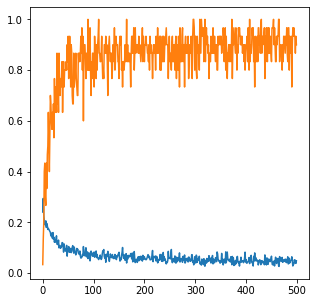

In [47]:
# make nn
class NN:
    def __init__(self, l1, l2):
        self.l1 = Tensor(l1)
        self.l2 = Tensor(l2)

    def forward(self, x):
        # x = x.dot(self.l1)
        # x = x.relu()
        # x = x.dot(self.l2)
        # return x.log_softmax()

        return x.dot(self.l1).relu().dot(self.l2).log_softmax()

# init weight
def weight_init(w: int, h: int , mode = 'gauss') -> np.array:
    """
    w : columns, Width.
    h : rows, Height.
    mode : ['gaussian', 'uniform'] 
    https://discuss.pytorch.org/t/how-are-layer-weights-and-biases-initialized-by-default/13073   
    """
    if mode == 'gauss':
        w = np.random.randn(w, h) / np.sqrt(w*h)
    else:
        w = np.random.uniform(-1, 1, size = (w, h)) / np.sqrt(w*h)
    return w.astype(np.float32)


np.random.seed(13)
lr = 0.001
batch = 30
l1 = weight_init(784, 128, mode = 'uniform')
l2 = weight_init(128, 10, mode = 'uniform')

model = NN(l1, l2)


bar = trange(500)
accuracies, losses = [], []
for i in bar:
    samp = np.random.randint(0, x.shape[0], size=(batch))
    X = Tensor(x[samp].reshape((-1, 28*28)))
    Y = y[samp]
    z = np.zeros((len(samp), 10))
    z[range(z.shape[0]), Y] = 1
    z = Tensor(z)

    y_ = model.forward(X)
    # mean
    # x_loss = (-out * x_lsm).mean(axis=1)
    p1 = y_.mul(z)
    loss = p1.sum().mul(Tensor(np.array([-1/y_.data.size]))) # add minus
    # set_trace()
    loss.backward()

    cat = np.argmax(y_.data, axis=1)
    acc = (cat == Y).mean()
    # SGD
    model.l1.data = model.l1.data - lr*model.l1.grad
    model.l2.data = model.l2.data - lr*model.l2.grad
    # printing
    loss = loss.data
    losses.append(loss)
    accuracies.append(acc)
    bar.set_description('Loss:  %.3f, Accuracy: %.3f' % (loss, acc)) 
figsize(5, 5)
plot(losses)
plot(accuracies)

Accuracy model:  0.9148
Bad count:  852

Predicted:  [6 7 2 6 9 4 5 3 9 2 4 1] Target [5 8 3 5 4 7 8 8 3 9 9 7]


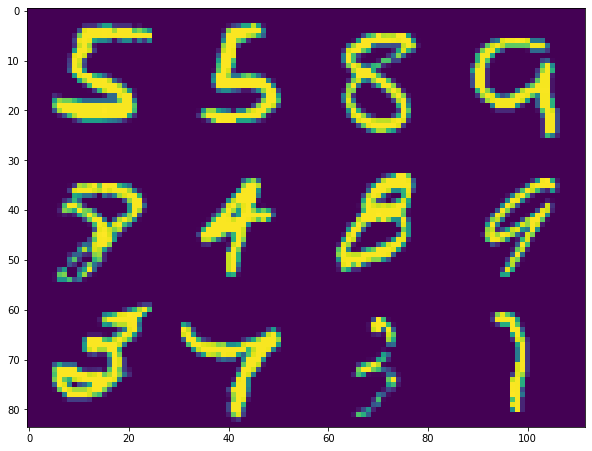

In [48]:
def vis_same_error(y_test_t, pred)-> None:

    idx = np.argwhere(y_test_t.data != pred)
    bad = x_test[idx]  
    tmp = []
    for _ in range(12):
        tmp.append(np.random.randint(bad.shape[0]))
    
    figsize(10, 10)
    imshow(np.concatenate(bad[tmp].reshape(4, 28*3, 28), axis = 1))
    print('')
    print('Predicted: ', pred[idx][tmp].ravel(), 'Target', y_test_t.data[idx][tmp].ravel())


def evaluate(model, x, y)-> None:
    y_= model.forward(x)
    # print(y_.data.shape)
    pred =  np.argmax(y_.data, axis =1)
    acc = (y.data == pred).mean()
    print('Accuracy model: ', acc)
    print('Bad count: ', int(y.data.shape[0] * (1 - acc)))
    vis_same_error(y_test_t, pred)


x_test_t = Tensor(x_test.reshape(-1, 28*28))
y_test_t = Tensor(y_test)
evaluate(model, x_test_t, y_test_t)

TODO

- make cov
- make adam
-